In [1]:
import psycopg2
import psycopg2.extensions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=18)

In [2]:
dsn = "postgresql://michael:@/landuse?host=/run/postgresql"

In [3]:
conn = psycopg2.connect(**psycopg2.extensions.parse_dsn(dsn))

In [4]:
def send_sql(connection, query, **kwargs):
    import time
    args = kwargs.get("args")
    quiet = kwargs.get("quiet", False)
    return_result = kwargs.get("return_result", False)
    start = time.time()
    cursor = connection.cursor()
    result = None
    rowcount = -1
    try:
        cursor.execute(query, args)
        rowcount = cursor.rowcount
        if return_result:
            result = cursor.fetchall()
        connection.commit()
    except Exception as ex:
        print("Failed to execute SQL statement:\n{}\nReason: {}".format(cursor.query, ex))
        connection.rollback()
    finally:
        cursor.close()
        msg = "Executed SQL command in {:0.3f} seconds.".format(time.time() - start)
        if rowcount >= 0:
            msg = "{}, affected {} rows.".format(msg[:-1], rowcount)
        print(msg)
    return result

def figsize_in(width_px, height_px):
    return [width_px / 100, height_px / 100]

## Prepare database

We have to make the area_id column of the table `land` unique and calculate the area of each polygon.

In [ ]:
send_sql(conn, "ALTER TABLE land ADD CONSTRAINT area_id_unique UNIQUE(area_id);")

Optimize Nominatim country grid:

In [ ]:
sql = """DROP TABLE IF EXISTS country_grid;
CREATE TABLE country_grid AS
SELECT country_code, ST_SetSRID((ST_Dump(geometry)).geom, 4326) AS geom
  FROM country_osm_grid;
"""
send_sql(conn, sql) # 1 second
send_sql(conn, "CREATE INDEX IF NOT EXISTS country_grid_geom ON country_grid USING gist(geom);")

Create a database table containing a grid within the clipping area:

In [ ]:
xmin = -24.6
ymin = 33.9
xmax = 46.76
ymax = 80.9
tilesize = 0.12

sql = """DROP TABLE IF EXISTS grid_cells_raw;
CREATE TABLE grid_cells_raw (
    id        SERIAL,      
    x1        DOUBLE PRECISION,
    y1        DOUBLE PRECISION,
    in_or_near_water BOOLEAN DEFAULT FALSE,
    at_coastline BOOLEAN DEFAULT FALSE,
    updated BOOLEAN DEFAULT FALSE,
    geom geometry(MultiPolygon, 4326)
);
CREATE VIEW tiles AS
  SELECT *
    FROM generate_series({xmin}, {xmax}, {tilesize}) AS x, generate_series({ymin}, {ymax}, {tilesize}) AS y;
CREATE VIEW bbox AS
  SELECT x AS x1, y AS y1, (x + {tilesize}) AS x2, (y + {tilesize}) AS y2
    FROM tiles;
INSERT INTO grid_cells_raw (x1, y1, geom)
  SELECT
      x1,
      y1,
      ST_SetSRID(ST_Multi(ST_MakeBox2D(ST_MakePoint(b.x1, b.y1), ST_MakePoint(b.x2, b.y2))), 4326) AS geom
    FROM bbox AS b;
DROP VIEW bbox;
DROP VIEW tiles;
CREATE INDEX grid_cells_raw_geom_idx ON grid_cells_raw USING GIST(geom);
ALTER TABLE grid_cells_raw ALTER COLUMN geom TYPE geometry(Geometry, 4326);
CREATE INDEX grid_cells_raw_id ON grid_cells_raw USING btree(id);
""".format(xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, tilesize=tilesize)
send_sql(conn, sql) # 4 seconds

Clip grid cells to clipping poly file of the OSM extract:

In [ ]:
response = send_sql(conn, "SELECT wkb_geometry, ST_Boundary(wkb_geometry) FROM clipping_area", return_result=True)
clipping_area = response[0][0]
clipping_bounds = response[0][1]
sql = """UPDATE grid_cells_raw AS g
  SET geom = ST_CollectionExtract(ST_Intersection(g.geom, %s), 3)
  WHERE geom && %s AND ST_Intersects(geom, %s);
""" # Europe: 2 seconds
send_sql(conn, sql, args=(clipping_area, clipping_bounds, clipping_bounds))
sql = """DELETE FROM grid_cells_raw
  WHERE NOT ST_Intersects(geom, %s);
""" # Europe: 1 second
send_sql(conn, sql, args=(clipping_area,))

Delete grid cells not covered by `country_grid`:

In [ ]:
sql = """DELETE FROM grid_cells_raw
  WHERE
    id NOT IN (
      SELECT
          g.id
        FROM grid_cells_raw AS g
        JOIN country_grid AS c
          ON g.geom && c.geom AND ST_Intersects(g.geom, c.geom)
    );
"""
send_sql(conn, sql) # Europe: 2 seconds

Delete grid cells covered by ocean:

In [ ]:
sql = """DELETE FROM grid_cells_raw
  WHERE id IN (
    SELECT g.id AS id
      FROM grid_cells_raw AS g
      JOIN water_polygons_split AS w
        ON g.geom && w.wkb_geometry AND ST_Covers(w.wkb_geometry, g.geom)
    );
"""
send_sql(conn, sql) # Europe: 44 seconds
sql = """UPDATE grid_cells_raw AS g
  SET in_or_near_water = TRUE
  FROM water_polygons_split AS w
  WHERE g.geom && w.wkb_geometry AND ST_Intersects(g.geom, w.wkb_geometry);
"""
send_sql(conn, sql) ## Europe: 44 seconds
sql = """UPDATE grid_cells_raw
  SET at_coastline = TRUE
  FROM coastlines_split AS c
  WHERE c.wkb_geometry && geom AND ST_Intersects(c.wkb_geometry, geom);
"""
send_sql(conn, sql) # Europe: 13 seconds
send_sql(conn, "CREATE INDEX IF NOT EXISTS grid_cells_raw_near_water_id ON grid_cells_raw USING btree(id) WHERE in_or_near_water;")
send_sql(conn, "DELETE FROM grid_cells_raw WHERE in_or_near_water AND NOT at_coastline;") # 1 second
# The final UPDATE query clipping at the coastline takes more than 13 minutes.
# Any intersection/difference operation with water body or land takes ages.
# Therefore we skip this step and have to get along with grid cells not clipped to the coast.
#send_sql(conn, "ALTER TABLE water_polygons_split ADD COLUMN near_grid_cell BOOLEAN DEFAULT FALSE;")
#sql = """UPDATE water_polygons_split AS w
#  SET near_grid_cell = TRUE
#  FROM grid_cells_raw AS g
#  WHERE g.geom && w.wkb_geometry AND ST_Intersects(g.geom, w.wkb_geometry);
#"""
send_sql(conn, sql) # Europe: 11 seconds 
#send_sql(conn, "CREATE INDEX IF NOT EXISTS grid_cells_raw_near_water_geom ON grid_cells_raw USING gist(geom) WHERE in_or_near_water;")
#send_sql(conn, "CREATE INDEX IF NOT EXISTS water_polygons_split_near_grid_cell ON water_polygons_split USING gist(wkb_geometry) WHERE near_grid_cell;")
#send_sql(conn, "CREATE INDEX grid_cells_raw_at_coastline ON grid_cells_raw USING gist(geom) WHERE at_coastline;")
#sql = """UPDATE grid_cells_raw AS g
#  SET
#    geom = ST_CollectionExtract(ST_Difference(g.geom, water_geom), 3),
#    updated = TRUE
#  FROM (
#    SELECT
#        geom,
#        ST_Union(w.wkb_geometry) AS water_geom,
#        id
#      FROM grid_cells_raw as g
#      JOIN water_polygons_split AS w
#        ON g.at_coastline AND g.geom && w.wkb_geometry AND ST_Intersects(g.geom, w.wkb_geometry)
#      GROUP BY id, geom
#  ) AS b
#  WHERE g.id = b.id;
#"""

Intersect grid cells with country grid to get analysis clipped to national borders.

In [ ]:
send_sql(conn, "DROP TABLE IF EXISTS grid_cells;")
sql = """CREATE TABLE grid_cells AS
SELECT
    g.id AS old_id,
    ST_CollectionExtract(ST_Intersection(g.geom, ST_Union(c.geom)), 3) AS geom,
    c.country_code AS country_code
  FROM grid_cells_raw AS g
  JOIN country_grid AS c
    ON g.geom && c.geom AND ST_Intersects(g.geom, c.geom)
  GROUP BY g.id, c.country_code, g.geom;
ALTER TABLE grid_cells DROP COLUMN old_id;
ALTER TABLE grid_cells ADD COLUMN id SERIAL PRIMARY KEY;
UPDATE grid_cells SET geom = ST_SetSRID(geom, 4326);
"""
send_sql(conn, sql) # Europe: 30 seconds
send_sql(conn, "CREATE INDEX grid_cells_geom_idx ON grid_cells USING gist(geom);")

## Landuse polygons clipped to grid cells

In [ ]:
send_sql(conn, "DROP TABLE IF EXISTS landuse_by_cell;")
grid_resolution = 0.00000001
sql = """CREATE TABLE landuse_by_cell AS
SELECT
    ST_Area(geom::geography) AS area,
    area_id,
    cell_id,
    feature,
    tags,
    geom
  FROM (
    SELECT
        l.area_id AS area_id,
        c.id AS cell_id,
        l.feature AS feature,
        l.tags AS tags,
        CASE
          WHEN ST_Within(l.geom, c.geom) THEN ST_SnapToGrid(l.geom, {grid_resolution})
          ELSE ST_SnapToGrid(ST_CollectionExtract(ST_Intersection(l.geom, c.geom), 3), {grid_resolution})
        END AS geom
      FROM land AS l
      JOIN grid_cells AS c
        ON l.geom && c.geom AND ST_Intersects(l.geom, c.geom) AND ST_Relate(l.geom, c.geom, 'T********')
  ) AS a;
""".format(grid_resolution=grid_resolution)
# 36 minutes; 22 seconds for Baden-Württemberg
send_sql(conn, sql)
#send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_by_cell_id ON landuse_by_cell USING BTREE(cell_id);")
#send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_by_cell_geom ON landuse_by_cell USING GIST(geom);")
#send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_by_cell_area ON landuse_by_cell USING BTREE(area);")

## A dataset of non-overlapping landuse

In OpenStreetMap, landuse polygons often overlap each other – often in the case when one landuse is a "hole" within another polygon (e.g. lake inside a forest). Before we can reliably determine a matrix of neighbouring landuse classes, we have to get rid of all overlaps.

In [6]:
snapping_resolution = 0.000000001

In [7]:
send_sql(conn, "DROP TABLE IF EXISTS landuse_by_cell_snapped;")
sql = """CREATE TABLE landuse_by_cell_snapped AS
  SELECT
      area_id,
      cell_id,
      feature,
      geom,
      ST_Boundary(geom) AS boundary_geom),
      area
    FROM (
      SELECT
        area_id,
        cell_id,
        feature,
        ST_Buffer(ST_SnapToGrid((ST_Dump(geom)).geom, %s), 0.0) AS geom,
        area
      FROM landuse_by_cell
    ) AS a;
"""
send_sql(conn, sql, args=(snapping_resolution,))
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_by_cell_snapped_geom ON landuse_by_cell_snapped USING gist(geom);")
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_by_cell_snapped_boundary_geom ON landuse_by_cell_snapped USING gist(boundary_geom);")
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_by_cell_snapped_id ON landuse_by_cell_snapped USING BTREE(cell_id);")
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_by_cell_snapped_area ON landuse_by_cell_snapped USING BTREE(area);")
send_sql(conn, "DROP TABLE IF EXISTS landuse_by_cell_without_overlaps;")
sql = """CREATE TABLE landuse_by_cell_without_overlaps AS
SELECT
    l.area_id AS area_id,
    l.cell_id AS cell_id,
    l.feature AS feature,
    ST_CollectionExtract(
      ST_Difference(
        l.geom,
        ST_Union(o.geom)
      ),
    3) AS geom
  FROM landuse_by_cell_snapped AS l
  JOIN landuse_by_cell_snapped AS o
    ON o.area < l.area AND ST_Intersects(l.geom, o.geom) AND ST_Relate(l.geom, o.geom, 'T********') AND l.geom && o.geom AND l.area_id <> o.area_id AND l.cell_id = o.cell_id
  GROUP BY l.area_id, l.cell_id, l.feature, l.geom;
"""
send_sql(conn, sql) # Baden-Württemberg: 110 seconds, Germany: 1046 seconds, Europe: 8528 seconds
send_sql(conn, "CREATE INDEX land_without_overlaps_geom_idx ON landuse_by_cell_without_overlaps USING gist(geom);")

Executed SQL command in 0.002 seconds.
Executed SQL command in 8528.171 seconds, affected 2865873 rows.
Executed SQL command in 25.711 seconds.


The same with landuse polygons that do not contain overlapping areas:

In [ ]:
sql = """INSERT INTO landuse_by_cell_without_overlaps (area_id, feature, geom)
SELECT 
    l.area_id AS area_id,
    l.feature AS feature,
    l.geom AS geom
  FROM landuse_by_cell AS l
  LEFT OUTER JOIN landuse_by_cell AS o
    ON o.area < l.area AND ST_Intersects(l.geom, o.geom) AND ST_Relate(l.geom, o.geom, 'T********') AND l.geom && o.geom AND l.area_id <> o.area_id AND l.cell_id = o.cell_id
  WHERE o.geom IS NULL; 
"""
send_sql(conn, sql) # Baden-Württemberg: 141 seconds, Germany: 2352 seconds

## Landuse coverage per cell

Overlaps were eliminated in a previous step.

In [9]:
send_sql(conn, "DROP TABLE IF EXISTS landuse_coverage_per_cell;")
sql = """CREATE TABLE landuse_coverage_per_cell AS
SELECT
    c.id AS cell_id,
    ST_Area(c.geom::geography) AS cell_area,
    SUM(ST_Area(l.geom::geography)) AS area_size,
    c.geom AS cell_geom
  FROM grid_cells AS c
  LEFT OUTER JOIN landuse_by_cell_without_overlaps AS l ON c.id = l.cell_id
  GROUP BY c.id, c.geom;
"""
send_sql(conn, sql) # 8 seconds for Baden-Württemberg, 43 for Germany
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_coverage_per_cell_id ON landuse_coverage_per_cell USING BTREE(cell_id);")
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_coverage_per_cell_geom ON landuse_coverage_per_cell USING GIST(cell_geom);")

Executed SQL command in 0.000 seconds.
Executed SQL command in 251.857 seconds, affected 73944 rows.
Executed SQL command in 0.088 seconds.
Executed SQL command in 0.414 seconds.


## Area of landuse by feature classes

In [10]:
sql = """DROP TABLE IF EXISTS landuse_feature_class_areas;
CREATE TABLE landuse_feature_class_areas AS
SELECT
    feature,
    SUM(ST_Area(geom::geography)) AS area_size
  FROM land
  GROUP BY feature;
"""
send_sql(conn, sql) # 11 seconds for Baden-Württemberg, 73 for Germany

Executed SQL command in 585.987 seconds, affected 1460 rows.


Plot size of landuse classes. We plot the largest ones only and no pie plot because there are overlaps and unmapped areas.

Executed SQL command in 0.008 seconds, affected 1460 rows.


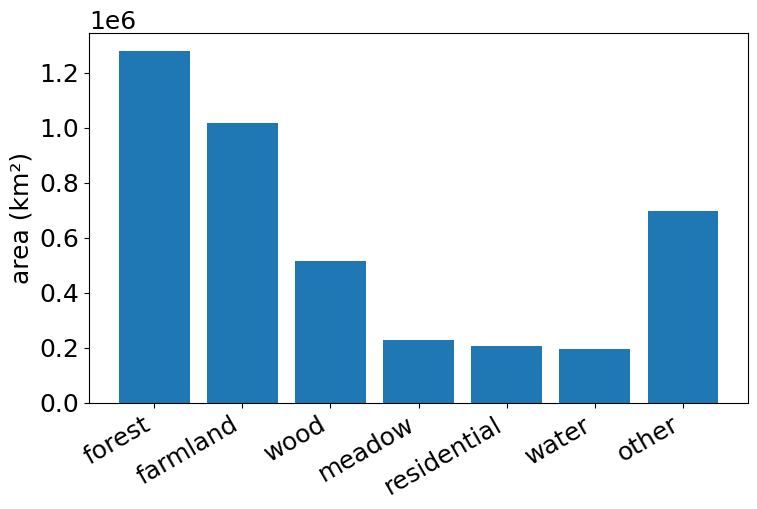

In [16]:
results = send_sql(conn, "SELECT feature, area_size FROM landuse_feature_class_areas ORDER BY area_size DESC;", return_result=True)
max_cols = 7
max_cols = min(max_cols, len(results))
all_classes_area_size = sum([r[1] for r in results])
classes = [r[0] for r in results[0:max_cols-1]]
area_sizes = [r[1] for r in results[0:max_cols-1]]

classes.append("other")
area_sizes.append(all_classes_area_size - sum(area_sizes))
area_sizes = [a / 10**6  for a in area_sizes]
fig, ax = plt.subplots(figsize=figsize_in(850, 480))
ax.bar(classes, area_sizes)
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('area (km²)')
plt.show()
fig.savefig('talk/plots/feature_classes_with_overlaps.svg', facecolor='white', bbox_inches='tight')

No the same without overlaps:

In [ ]:
sql = """DROP TABLE IF EXISTS landuse_feature_class_area_without_overlaps;
CREATE TABLE landuse_feature_class_area_without_overlaps AS
SELECT
    feature,
    SUM(ST_Area(geom::geography)) AS area_size
  FROM landuse_by_cell_without_overlaps
  GROUP BY feature;
"""
send_sql(conn, sql) # BW: 14 seconds, Germany: 91 seconds
results = send_sql(conn, "SELECT feature, area_size FROM landuse_feature_class_area_without_overlaps ORDER BY area_size DESC;", return_result=True)
total_area_size = send_sql(conn, "SELECT SUM(ST_Area(geom::geography)) FROM grid_cells;", return_result=True)[0][0]
all_classes_area_size_no = sum([r[1] for r in results])
area_sizes_no = []
classes2 = [c for c in classes]
for c in classes2:
    for row in results:
        if row[0] == c:
            area_sizes_no.append(row[1])
if classes2[-1] == 'other':
    area_sizes_no.append(all_classes_area_size_no - sum(area_sizes_no))
classes2.append('none')
area_sizes2 = [a for a in area_sizes]
area_sizes2.append(0)
area_sizes_no.append(total_area_size - all_classes_area_size_no)
data = {
    'with overlaps': area_sizes2,
    'without overlaps': [ a / 10**6 for a in area_sizes_no],
}
colors = {
    'with overlaps': 'tab:red',
    'without overlaps': 'tab:blue',
}
x = np.arange(len(classes2))
fig, ax = plt.subplots(figsize=figsize_in(830, 590))
width = 1.0 / 3
multiplier = 0

for with_without, values in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=with_without, color=colors[with_without])
    #ax.bar_label(rects, padding=2, fmt='%.0f')
    multiplier += 1

ax.set_ylabel('area (km²)')
plt.xticks(rotation=22, ha='right')
#ax.set_title('Featureklassen mit und ohne Überlappungen')
ax.set_xticks(x + 0.5 * width, classes2)
ax.legend(loc='upper left', ncol=2)
ax.set_ylim(0, 1.2 * max(area_sizes2))
plt.show()
fig.savefig('talk/plots/feature_classes_without_overlaps.svg', facecolor='white')

## Overlaps of landuse

Find intersections between landuse polygons:

In [19]:
send_sql(conn, "CREATE INDEX IF NOT EXISTS land_area_size_idx ON land USING btree(area);")
send_sql(conn, "DROP TABLE IF EXISTS landuse_overlaps;")
sql = """CREATE TABLE landuse_overlaps AS
SELECT
    ST_CollectionExtract(
      ST_Intersection(
        a.geom,
        b.geom
      ),
    3) AS geom,
    a.area_id AS id1,
    b.area_id AS id2,
    a.feature AS feature1,
    b.feature AS feature2,
    a.area AS size_1,
    b.area AS size_2
  FROM landuse_by_cell_snapped AS a
  JOIN landuse_by_cell_snapped AS b
    ON
    a.area >= b.area
    AND a.geom && b.geom
    AND ST_Intersects(a.geom, b.geom)
    AND ST_Relate(a.geom, b.geom, 'T********')
    AND a.area_id != b.area_id;
"""
send_sql(conn, sql) # 82 seconds for Baden-Württemberg, 854 seconds for Germany

Executed SQL command in 0.001 seconds.
Executed SQL command in 0.045 seconds.
Executed SQL command in 6479.518 seconds, affected 10843295 rows.


Create a matrix of feature classes overlapping each other by area. `feature1` is the larger polygon, `feature2` the smaller one.

In [20]:
send_sql(conn, "DROP TABLE IF EXISTS landuse_overlaps_feature_classes;")
sql = """CREATE TABLE landuse_overlaps_feature_classes AS
SELECT
    feature1,
    feature2,
    SUM(ST_Area(geom::geography)) AS area_size,
    COUNT(1) AS occurences
  FROM landuse_overlaps
  GROUP BY feature1, feature2;
"""
send_sql(conn, sql) # 2 seconds for Baden-Württemberg, 9 seconds for Germany

Executed SQL command in 0.001 seconds.
Executed SQL command in 75.966 seconds, affected 10485 rows.


Find most important feature classes for a matrix:

Executed SQL command in 0.027 seconds, affected 10485 rows.
0.5


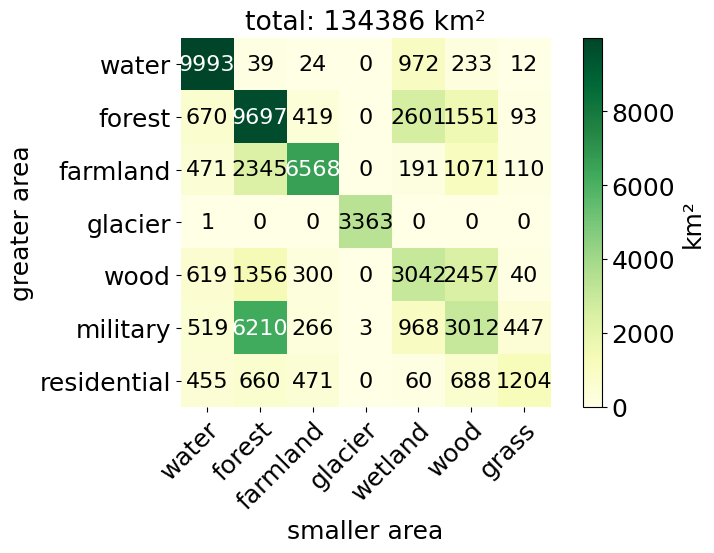

In [17]:
sql = """SELECT
    feature1,
    feature2,
    area_size
  FROM landuse_overlaps_feature_classes
  ORDER BY area_size DESC;
"""
matches = send_sql(conn, sql, return_result=True)
# Conversion factor from square meter to km^2
factor = 10**6
total_overlapping_area = sum([m[2] for m in matches]) / factor
max_classes = 7
left = []
top = []
# Find at most max_matches classes for left and top labels.
for row in matches:
    if row[0] == 'plateau' or row[1] == 'plateau':
        continue
    if len(left) < max_classes and len(top) < max_classes and row[0] not in left and row[1] not in top:
        left.append(row[0])
        top.append(row[1])
values = np.zeros((max_classes, max_classes))
for row in matches:
    if row[0] in left and row[1] in top:
        left_idx = left.index(row[0])
        top_idx = top.index(row[1])
        values[left_idx][top_idx] = row[2]
# Convert to ha
values = values / factor
fig, ax = plt.subplots(figsize=figsize_in(850, 480))
im = ax.imshow(values, cmap='YlGn')
colorbar = ax.figure.colorbar(im, ax=ax)
colorbar.ax.set_ylabel('km²')
plt.rc('font', size=16)
ax.set_xticks(np.arange(len(top)), labels=top)
ax.set_ylabel('greater area')
ax.set_yticks(np.arange(len(left)), labels=left)
ax.set_xlabel('smaller area')
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.spines[:].set_visible(False)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
threshold = im.norm(values.max()) / 2.0
print(threshold)
for i in range(len(left)):
    for j in range(len(top)):
        color = 'white'
        if im.norm(values[i, j]) < threshold:
            color = 'black'
        text = ax.text(j, i, "{:.0f}".format(values[i, j]), ha="center", va="center", color=color)

ax.set_title("total: {:.0f} km²".format(total_overlapping_area))
#fig.tight_layout()
plt.show()
fig.savefig('talk/plots/overlaps_matrix.svg', facecolor='white', bbox_inches='tight')
plt.rc('font', size=18)

Drop distinction between larger and smaller polygons, just make a matrix of landuse classes:

In [22]:
send_sql(conn, "DROP TABLE IF EXISTS landuse_overlaps_feature_classes_ordered;")
sql = """CREATE TABLE landuse_overlaps_feature_classes_ordered AS
SELECT
    f1 AS feature1,
    f2 AS feature2,
    SUM(area_size) AS area_size,
    COUNT(1) AS occurences
  FROM (
    SELECT
        CASE WHEN feature1 < feature2 THEN feature1 ELSE feature2 END AS f1,
        CASE WHEN feature1 < feature2 THEN feature2 ELSE feature1 END AS f2,
        ST_Area(geom::geography) AS area_size
      FROM landuse_overlaps
  ) AS a
  GROUP BY f1, f2;
"""
send_sql(conn, sql) # Baden-Württemberg: 2 seconds, Germany: 10 seconds

Executed SQL command in 0.001 seconds.
Executed SQL command in 80.176 seconds, affected 7724 rows.


## Generic stats about landuses (sizes, node count, boundary length)

Get boundary lines of landuse polygons (as (multi)linestrings) and the area size.

In [23]:
send_sql(conn, "DROP TABLE IF EXISTS landuse_boundary_lines;")
sql = """CREATE TABLE landuse_boundary_lines AS
SELECT
    ST_Boundary(geom) AS geom,
    ST_Length(ST_Boundary(geom)::geography) AS length,
    ST_NPoints(geom) AS node_count,
    ST_Area(geom::geography) AS area_size,
    area_id,
    feature,
    tags
  FROM land;
"""
send_sql(conn, sql) # Baden-Württemberg 15 seconds, Germany: 118 seconds
#send_sql(conn, "CREATE INDEX landuse_boundary_lines_length_idx ON landuse_boundary_lines USING btree(length);")
#send_sql(conn, "CREATE INDEX landuse_boundary_lines_node_count_idx ON landuse_boundary_lines USING btree(node_count);")
#send_sql(conn, "CREATE INDEX landuse_boundary_lines_area_size_idx ON landuse_boundary_lines USING btree(area_size);")

Executed SQL command in 0.001 seconds.
Executed SQL command in 1109.104 seconds, affected 42340705 rows.


Find polygons with long boundary but small area size:

In [24]:
sql = '''SELECT
      area_id,
      feature,
      (sqrt(area_size)/length) AS size_length_ratio,
      area_size
    FROM landuse_boundary_lines
  ORDER BY size_length_ratio ASC NULLS LAST;
'''

Find polygons with many nodes per boundary length:

In [25]:
sql = '''SELECT
        area_id,
        feature,
        area_size,
        (length/node_count::REAL) AS length_by_nodes,
        length,
        node_count
      FROM landuse_boundary_lines
      ORDER BY length_by_nodes ASC NULLS LAST;
'''

Unfortunately, the result is a bit worthless. The lowest ratio of length and node count is found at small circular areas (less than 1 m²). The largest ratio is found at rectangular forests (or rectangular grass areas on airports). This is not interesting.

In [26]:
sql = '''SELECT
        area_id,
        feature,
        area_size,
        (node_count::REAL/area) AS nodes_per_area,
        length,
        node_count
      FROM landuse_boundary_lines
      ORDER BY length_by_nodes ASC NULLS LAST;
'''

The ratio of node count and area size does not return better results. The top and bottom entries of the list are almost identical.

Grid cells with many/few nodes per area:

In [27]:
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_boundary_lines_geom_idx ON landuse_boundary_lines USING gist(geom);")
send_sql(conn, "DROP TABLE IF EXISTS nodes_per_grid_cell;")
sql = '''CREATE TABLE nodes_per_grid_cell AS
SELECT
    cell_id,
    node_count/(ST_Area(area::geography) / 10000) AS nodes_per_area
  FROM (
    SELECT
        c.id AS cell_id,
        SUM(ST_NPoints(ST_Intersection(c.geom, b.geom))) AS node_count,
        c.geom AS area
      FROM grid_cells AS c
      JOIN landuse_boundary_lines AS b
        ON
          c.geom && b.geom
          AND ST_Intersects(c.geom, b.geom)
          -- ST_Relate makes queries slower.
          -- AND ST_Relate(c.geom, b.geom, 'T********')
      GROUP BY c.id, area
  ) AS a
  ORDER BY node_count DESC NULLS LAST;
'''
send_sql(conn, sql) # Baden-Württemberg: 27 seconds, Germany: 73 seconds

Executed SQL command in 483.596 seconds.
Executed SQL command in 0.001 seconds.
Executed SQL command in 2210.327 seconds, affected 71957 rows.


**TODO**

* determine node count per area and per boundary length, its distribution and differences between municipalities
* clip landuse boundaries to municipal polygons
* determine ratio of sqrt(area size) to boundary length, its distribution and differences between municipalities

## Multipolygons vs. simple polygons

Get the number of multipolygons vs. simple polygons for all feature classes:

In [28]:
sql = """DROP TABLE IF EXISTS multipolygon_landuse_stats;
-- We have to use landuse_by_cell as source because we do not want to include polygons outside of Germany.
CREATE INDEX IF NOT EXISTS landuse_by_cell_id_feature ON landuse_by_cell USING btree(area_id, feature);
CREATE TABLE multipolygon_landuse_stats AS
SELECT
    feature,
    COUNT(landuse_id) AS feature_count,
    (landuse_id < 0) AS is_multipolygon,
    SUM(area_size) AS area_size
  FROM (
    SELECT
        area_id AS landuse_id,
        feature,
        SUM(ST_Area(geom::geography)) AS area_size
      FROM landuse_by_cell
      GROUP BY landuse_id, feature
    ) AS a
  GROUP BY feature, (landuse_id < 0);
"""
send_sql(conn, sql) # Baden-Württemberg: 9 seconds, Germany: 73 seconds

Executed SQL command in 594.275 seconds, affected 1753 rows.


Executed SQL command in 0.008 seconds, affected 1753 rows.


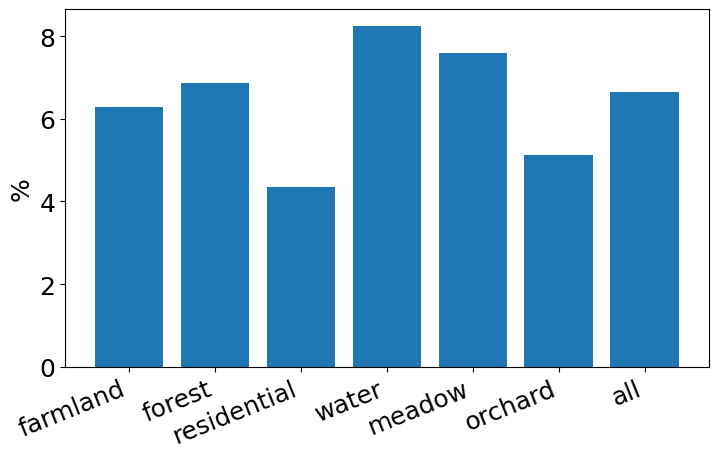

In [18]:
results = send_sql(
    conn,
    "SELECT feature, is_multipolygon, feature_count FROM multipolygon_landuse_stats ORDER BY feature, is_multipolygon;",
    return_result=True)
interesting_feature_classes = ["farmland", "forest", "residential", "water", "meadow", "orchard"]
results = [row for row in results if row[0] in interesting_feature_classes]
all_feature_count = sum([row[2] for row in results])
mp_feature_count = sum([row[2] for row in results if row[1]])
values = [[0, 0] for x in range(len(interesting_feature_classes))]
for i in range(len(interesting_feature_classes)):
    fclass = interesting_feature_classes[i]
    for row in results:
        if fclass != row[0]:
            continue
        if row[1]:
            values[i][1] = row[2]
        else:
            values[i][0] = row[2]
fig, ax = plt.subplots(figsize=figsize_in(830, 490))
fractions = [v[1] / (v[0] + v[1]) for v in values]
classes = interesting_feature_classes + ['all']
fractions.append(mp_feature_count / all_feature_count)
fractions = [f * 100 for f in fractions]
ax.bar(classes, fractions)
fig.subplots_adjust(bottom=0.15)
plt.xticks(rotation=22, ha='right')
#ax.set_title('Anteil Multipolygone pro Featureklasse [%]')
ax.set_ylabel('%')
plt.show()
fig.savefig('talk/plots/multipolygons_vs_simple_polygons_bar.svg', facecolor='white', bbox_inches='tight')

Make statistics about multipolygon usage per feature class:

In [30]:
send_sql(conn, "DROP TABLE IF EXISTS multipolygon_landuse;")
sql = """CREATE TABLE multipolygon_landuse AS
SELECT
    geom,
    area_id,
    COUNT(1) AS outer_rings,
    SUM(ST_NumInteriorRing(dumped_geom)) AS inner_rings,
    mp_outer_way_count,
    feature,
    tags
  FROM (
    SELECT
        geom,
        area_id,
        (ST_Dump(geom)).geom AS dumped_geom,
        mp_outer_way_count,
        feature,
        tags
      FROM land
      WHERE area_id < 0
    ) AS a
  GROUP BY area_id, mp_outer_way_count, feature, tags, geom;
"""
send_sql(conn, sql) # Baden-Württemberg: 1 second

Executed SQL command in 0.000 seconds.
Executed SQL command in 177.205 seconds, affected 2721003 rows.


Unnecessary multipolygon per municipality:

In [31]:
send_sql(conn, "DROP TABLE IF EXISTS unnecessary_multipolygons_per_municipality;")
sql = """CREATE TABLE unnecessary_multipolygons_per_municipality AS
SELECT
    ST_CollectionExtract(ST_Intersection(c.geom, m.geom), 3) AS geom,
    m.feature AS feature,
    m.outer_rings AS outer_rings,
    m.inner_rings AS inner_rings,
    m.mp_outer_way_count AS outer_way_count,
    m.tags AS tags,
    c.id AS cell_id,
    m.area_id AS multipolygon_id
  FROM multipolygon_landuse AS m
  JOIN grid_cells AS c
    ON
      c.geom && m.geom
      AND ST_Intersects(c.geom, m.geom)
      AND ST_Relate(c.geom, m.geom, 'T********')
      AND (
        (m.outer_rings > 1 AND NOT m.tags?'name')
        OR (m.mp_outer_way_count > 1 AND m.outer_rings = 1)
      );
"""
send_sql(conn, sql) # Baden-Württemberg: 2 seconds
send_sql(conn, "CREATE INDEX IF NOT EXISTS unnecessary_multipolygons_per_municipality_city_id ON unnecessary_multipolygons_per_municipality USING BTREE(cell_id);")

Executed SQL command in 0.001 seconds.
Executed SQL command in 505.034 seconds, affected 1979451 rows.
Executed SQL command in 2.377 seconds.


Create table to store base values for the multipolygonitis score calculation:

In [32]:
send_sql(conn, "DROP TABLE IF EXISTS multipolygonitis_score;")
sql = """CREATE TABLE multipolygonitis_score AS
SELECT
    SUM(ST_Area(l.geom::geography)) AS landuse_area,
    COUNT(l.geom) AS landuse_count,
    a.multipolygon_area AS multipolygon_area,
    a.multipolygon_count AS multipolygon_count,
    a.cell_id AS cell_id,
    a.cell_area AS cell_area,
    a.cell_geom AS cell_geom
  FROM (
    SELECT
      SUM(ST_Area(m.geom::geography)) AS multipolygon_area,
      COUNT(m.geom) AS multipolygon_count,
      c.id AS cell_id,
      ST_Area(c.geom::geography) AS cell_area,
      c.geom AS cell_geom
    FROM grid_cells AS c
    LEFT OUTER JOIN unnecessary_multipolygons_per_municipality AS m
      ON m.cell_id = c.id
    GROUP BY c.id, c.geom
  ) AS a
  LEFT OUTER JOIN landuse_by_cell AS l
    ON l.cell_id = a.cell_id
  GROUP BY a.cell_id, a.multipolygon_area, a.cell_area, a.multipolygon_count, a.cell_geom;
"""
send_sql(conn, sql) # Baden-Württemberg: 22 seconds
send_sql(conn, "CREATE INDEX IF NOT EXISTS multipolygonitis_score_geom_idx ON multipolygonitis_score USING gist(cell_geom);")

Executed SQL command in 0.001 seconds.
Executed SQL command in 1608.344 seconds, affected 73944 rows.
Executed SQL command in 0.366 seconds.


Create a histogram of the distribution of unnecessary multipolygons:

Executed SQL command in 0.067 seconds, affected 72245 rows.


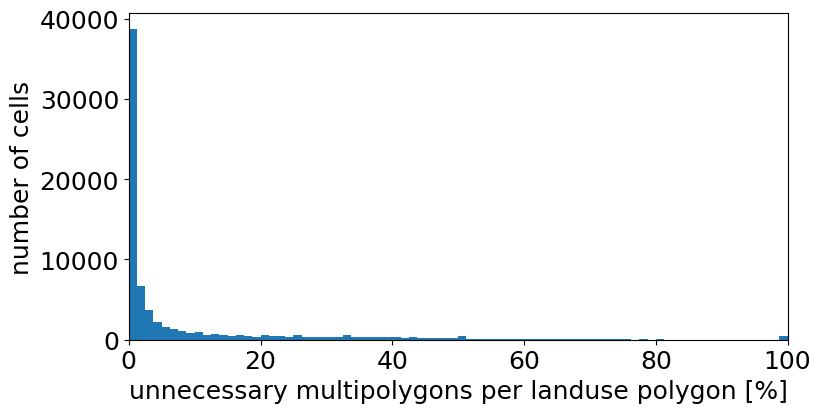

In [19]:
sql = """SELECT
    multipolygon_count::REAL/landuse_count::REAL AS ml
  FROM multipolygonitis_score
  WHERE landuse_count > 0;
"""
result = send_sql(conn, sql, return_result=True)
fig, ax = plt.subplots(figsize=figsize_in(850, 480))
dist = [row[0]*100 for row in result]
ax.hist(dist, bins=80)
ax.set_xlabel('unnecessary multipolygons per landuse polygon [%]')
ax.set_ylabel('number of cells')
fig.subplots_adjust(bottom=0.20)
ax.set_xlim(0.0, max(dist))
#ax.set_title('Verteilung des Multipolygonitis-Scores über die Gemeinden')
plt.show()
fig.savefig('talk/plots/multipolygonitis_histogram.svg', facecolor='white', bbox_inches='tight')

## Road segments which are used by landuse polygons

Get boundary lines of all landuse polygons:

In [45]:
sql = '''
DROP TABLE IF EXISTS landuse_boundaries;
CREATE TABLE landuse_boundaries AS
  SELECT
      ST_CollectionExtract(ST_SnapToGrid(ST_Boundary(geom), %s), 2) AS geom,
      area_id,
      feature,
      tags
    FROM land;
'''
send_sql(conn, sql, args=(snapping_resolution,)) # 244 seconds for Europe
send_sql(conn, "CREATE INDEX landuse_boundaries_geom_idx ON landuse_boundaries USING gist(geom);") # 472 seconds for Europe
send_sql(conn, "CREATE INDEX landuse_boundaries_id_idx ON landuse_boundaries USING btree(area_id);")

Executed SQL command in 243.689 seconds, affected 42340705 rows.
Executed SQL command in 472.363 seconds.
Executed SQL command in 17.283 seconds.


Get intersection of these boundary lines with other landuse boundary lines:

In [35]:
sql = '''
DROP TABLE IF EXISTS landuse_landuse_boundaries;
CREATE TABLE landuse_landuse_boundaries AS
SELECT
    ST_CollectionExtract(ST_Intersection(l1.geom, l2.geom), 2) AS geom,
    l1.feature AS feature1,
    l2.feature AS feature2,
    l1.area_id AS land_id1,
    l2.area_id AS land_id2,
    l1.tags AS tags1,
    l2.tags As tags2
  FROM landuse_boundaries AS l1
  JOIN landuse_boundaries AS l2
    -- Ensures that we do not get any duplicates.
    -- Using < instead of <> because this makes use of the index.
    ON l1.area_id < l2.area_id
    AND l1.geom && l2.geom
    AND ST_Intersects(l1.geom, l2.geom)
    -- Not using ST_Relate makes the query faster.
    -- AND ST_Relate(l1.geom, l2.geom, '1********');
'''
send_sql(conn, sql) # Baden-Württemberg: 171 seconds, Europe: 14012 seconds

Executed SQL command in 14012.335 seconds, affected 50343513 rows.


Create a table for snapped geometries of roads:

In [69]:
#sql = """
#DROP TABLE IF EXISTS streets_snapped;
#CREATE TABLE streets_snapped AS
#SELECT
#    way_id,
#    highway,
#    railway,
#    ST_SnapToGrid(geom, %s) AS geom
#  FROM streets;
#"""
#send_sql(conn, sql, args=(snapping_resolution,)) # Europe: 107 seconds
#send_sql(conn, "CREATE INDEX IF NOT EXISTS streets_snapped_geom ON streets_snapped USING gist(geom);") # Europe: 919 seconds

Executed SQL command in 107.422 seconds, affected 83147119 rows.
Executed SQL command in 919.313 seconds.


Find landuse polygons sharing their boundary with roads.

In [15]:
sql = """
DROP TABLE IF EXISTS landuse_boundaries_unsnapped;
CREATE TABLE landuse_boundaries_unsnapped AS
SELECT
    ST_Boundary(geom) AS geom,
    area_id,
    feature,
    tags
  FROM landuse_by_cell;
"""
send_sql(conn, sql) # Europe: 236s
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_boundaries_unsnapped_geom ON landuse_boundaries_unsnapped USING gist(geom)") # Europe: 505 seconds
sql = '''
DROP TABLE IF EXISTS landuse_boundaries_on_roads;
CREATE TABLE landuse_boundaries_on_roads AS
SELECT
    ST_CollectionExtract(
      ST_Intersection(
        l.geom,
        r.geom
      ),
    2) AS geom,
    l.feature AS land_feature,
    l.area_id AS land_id,
    COALESCE(r.highway, r.railway) AS road_feature,
    r.way_id AS road_id
  -- It is faster to use landuse_by_cell than landuse table (137 instead of 180 seconds for Baden-Württemberg).
  FROM landuse_boundaries_unsnapped AS l
  JOIN streets AS r ON l.geom && r.geom AND ST_Intersects(l.geom, r.geom) AND ST_Relate(l.geom, r.geom, '1********');
'''
send_sql(conn, sql) # Baden-Württemberg: 137 seconds, Germany: 794 seconds, Europe: 5176 seconds

Executed SQL command in 235.798 seconds, affected 44282585 rows.
Executed SQL command in 505.229 seconds.
Executed SQL command in 5176.536 seconds, affected 2436291 rows.


The table `landuse_boundaries_on_roads` contains duplicates if a road segment belongs to two landuse polygons. They are de-duplicated now:

In [16]:
sql = '''
DROP TABLE IF EXISTS roads_as_landuse_boundaries;
CREATE INDEX IF NOT EXISTS landuse_boundaries_on_roads_road_id_feature ON landuse_boundaries_on_roads USING btree(road_id, road_feature);
CREATE TABLE roads_as_landuse_boundaries AS
SELECT
-- merge geometries of roads with equal ID before we merge intersecting features
    ST_CollectionExtract(ST_Union(geom), 2) AS geom,
    road_feature,
    road_id
  FROM landuse_boundaries_on_roads
  GROUP BY road_id, road_feature;
'''
send_sql(conn, sql) # Baden-Württemberg: 4 seconds

Executed SQL command in 41.041 seconds, affected 1124604 rows.


Get a geometry collection of the roads of each municipality.

Performance notes:

* In the `SELECT` part, `ST_Within` is faster than using `ST_CoveredBy` or `ST_Relate` (saves 25%).
* In the `JOIN` condition, not using `ST_Relate(rl.geom, c.geom, '1********')` saves additional 90% of time.

In [49]:
send_sql(conn, "DROP TABLE IF EXISTS cells_road_network_length;")
sql = '''CREATE TABLE cells_road_network_length
  AS SELECT
    COALESCE(ST_Length(
      ST_Collect(ST_CollectionExtract(
        CASE
          WHEN ST_Within(rl.geom, c.geom) THEN rl.geom
          ELSE ST_Intersection(rl.geom, c.geom)
        END,
      2))::geography
    ), 0::REAL) AS road_length,
    c.id AS cell_id,
    c.geom AS cell_geom
  FROM grid_cells AS c
  LEFT OUTER JOIN streets AS rl
    ON c.geom && rl.geom AND ST_Intersects(c.geom, rl.geom)
  GROUP BY c.id, c.geom;
'''
send_sql(conn, sql) # Baden-Württemberg: 26 seconds, Germany: 164 seconds, Europe: 1231 s
send_sql(conn, "CREATE INDEX cells_road_network_length_area_id_idx ON cells_road_network_length USING btree(cell_id);")
send_sql(conn, "CREATE INDEX cells_road_network_length_geom_idx ON cells_road_network_length USING gist(cell_geom);")

Executed SQL command in 0.018 seconds.
Executed SQL command in 1231.037 seconds, affected 73944 rows.
Executed SQL command in 0.085 seconds.
Executed SQL command in 0.415 seconds.


Intersect length of this road network per municpality and get a GeometryCollection of all roads per municipality:

In [17]:
send_sql(conn, "CREATE INDEX IF NOT EXISTS roads_as_landuse_boundaries_geom_idx ON roads_as_landuse_boundaries USING GIST(geom);")
send_sql(conn, "DROP TABLE IF EXISTS roads_as_landuse_boundaries_per_cell;")
sql = """CREATE TABLE roads_as_landuse_boundaries_per_cell AS
SELECT
      COALESCE(ST_Collect(
        ST_CollectionExtract(
          CASE
            WHEN ST_Within(rl.geom, c.geom) THEN rl.geom
            ELSE ST_Intersection(rl.geom, c.geom)
          END,
          2)
      ), ST_SetSRID(ST_GeometryFromText('LINESTRING EMPTY'), 4326)) AS roads_geom,
      c.id AS cell_id,
      c.geom AS cell_geom
    FROM grid_cells AS c
    LEFT OUTER JOIN roads_as_landuse_boundaries AS rl
      ON
        c.geom && rl.geom
        AND ST_Intersects(c.geom, rl.geom)
    GROUP BY c.id, c.geom;
"""
send_sql(conn, sql) # 1 second for Baden-Württemberg, Europe: 16s
send_sql(conn, "CREATE INDEX IF NOT EXISTS roads_as_landuse_boundaries_per_cell_idx ON roads_as_landuse_boundaries_per_cell USING btree(cell_id);")

Executed SQL command in 6.929 seconds.
Executed SQL command in 0.016 seconds.
Executed SQL command in 15.566 seconds, affected 73944 rows.
Executed SQL command in 0.080 seconds.


Do the same for landuse boundaries on roads (if a road is used by two neighbouring landuse polygons, it will appear twice):

In [18]:
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_boundaries_on_roads_geom_idx ON landuse_boundaries_on_roads USING GIST(geom);")
send_sql(conn, "DROP TABLE IF EXISTS landuse_boundaries_on_roads_per_cell;")
sql = """CREATE TABLE landuse_boundaries_on_roads_per_cell AS
SELECT
      COALESCE(ST_Collect(
        ST_CollectionExtract(
          CASE
            WHEN ST_Within(rl.geom, c.geom) THEN rl.geom
            ELSE ST_Intersection(rl.geom, c.geom)
          END,
          2)
      ), ST_SetSRID(ST_GeometryFromText('LINESTRING EMPTY'), 4326)) AS roads_geom,
      c.id AS cell_id,
      c.geom AS cell_geom
    FROM grid_cells AS c
    LEFT OUTER JOIN landuse_boundaries_on_roads AS rl
      ON
        c.geom && rl.geom
        AND ST_Intersects(c.geom, rl.geom)
    GROUP BY c.id, c.geom;
"""
send_sql(conn, sql) # 2 seconds for Baden-Württemberg, Europe: 19s
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_boundaries_on_roads_per_cell_idx ON landuse_boundaries_on_roads_per_cell USING btree(cell_id);")

Executed SQL command in 19.564 seconds.
Executed SQL command in 0.016 seconds.
Executed SQL command in 19.268 seconds, affected 73944 rows.
Executed SQL command in 0.079 seconds.


In [19]:
sql = '''
DROP TABLE IF EXISTS landuse_boundaries_per_cell;
CREATE TABLE landuse_boundaries_per_cell
  AS SELECT
    COALESCE(ST_Collect(
      ST_CollectionExtract(
        CASE
          WHEN ST_Within(l.geom, c.geom) THEN l.geom
          ELSE ST_Intersection(l.geom, c.geom)
        END,
        2)
    ), ST_SetSRID(ST_GeometryFromText('LINESTRING EMPTY'), 4326)) AS geom,
    c.id AS cell_id,
    c.geom AS cell_geom
  FROM grid_cells AS c
  JOIN landuse_boundaries AS l ON c.geom && l.geom AND ST_Intersects(c.geom, l.geom)
  GROUP BY c.id, c.geom;
'''
send_sql(conn, sql) # 23 seconds for Baden-Württemberg, Germany: 163 seconds, Europe: 1994s
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_boundaries_per_cell_geom_idx ON landuse_boundaries_per_cell USING gist(geom);")
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_boundaries_per_cell_id_idx ON landuse_boundaries_per_cell USING btree(cell_id);")

Executed SQL command in 1994.541 seconds, affected 71955 rows.
Executed SQL command in 13.621 seconds.
Executed SQL command in 0.086 seconds.


Determine per cell how large the proportion of landuse boundaries glued to roads compared to all roads is.

In [21]:
send_sql(conn, "DROP TABLE IF EXISTS roads_landuse_boundary_fraction_per_cell;")
sql = """CREATE TABLE roads_landuse_boundary_fraction_per_cell AS
SELECT
    CASE WHEN landuse_boundary_length = 0.0 THEN 0.0
      ELSE landuse_boundaries_on_roads_length / landuse_boundary_length
    END AS landuse_boundaries_on_roads_fraction,
    landuse_boundaries_on_roads_length AS landuse_boundaries_on_roads,
    landuse_boundary_length,
    CASE WHEN road_network_length = 0.0 THEN 0.0
      ELSE roads_as_landuse_boundary_length / road_network_length
    END AS roads_as_landuse_boundary_fraction,
    roads_as_landuse_boundary_length,
    road_network_length,
    coverage_fraction,
    cell_id,
    cell_geom
FROM (
  SELECT
    COALESCE(ST_Length(br.roads_geom::geography), 0.0) AS landuse_boundaries_on_roads_length,
    COALESCE(ST_Length(b.geom::geography), 0.0) AS landuse_boundary_length,
    COALESCE(ST_Length(rb.roads_geom::geography), 0.0) AS roads_as_landuse_boundary_length,
    c.road_length AS road_network_length,
    cov.area_size/cov.cell_area AS coverage_fraction,
    c.cell_id AS cell_id,
    c.cell_geom AS cell_geom
  FROM cells_road_network_length AS c
  LEFT OUTER JOIN roads_as_landuse_boundaries_per_cell AS rb
    ON rb.cell_id = c.cell_id
  LEFT OUTER JOIN landuse_boundaries_per_cell AS b
    ON b.cell_id = c.cell_id
  LEFT OUTER JOIN landuse_boundaries_on_roads_per_cell AS br
    ON br.cell_id = c.cell_id
  LEFT OUTER JOIN landuse_coverage_per_cell AS cov
    ON cov.cell_id = c.cell_id
  WHERE c.road_length > 0.0
  ) AS a;
"""
send_sql(conn, sql) # 57 seconds for Baden-Württemberg, Germany: 282 seconds, Europe: 2399s
send_sql(conn, "CREATE INDEX IF NOT EXISTS roads_landuse_boundary_fraction_per_cell_geom_idx ON roads_landuse_boundary_fraction_per_cell USING gist(cell_geom);")

Executed SQL command in 0.023 seconds.
Executed SQL command in 2399.348 seconds, affected 69008 rows.
Executed SQL command in 0.367 seconds.


Plot a few histograms:

Executed SQL command in 0.066 seconds, affected 69008 rows.


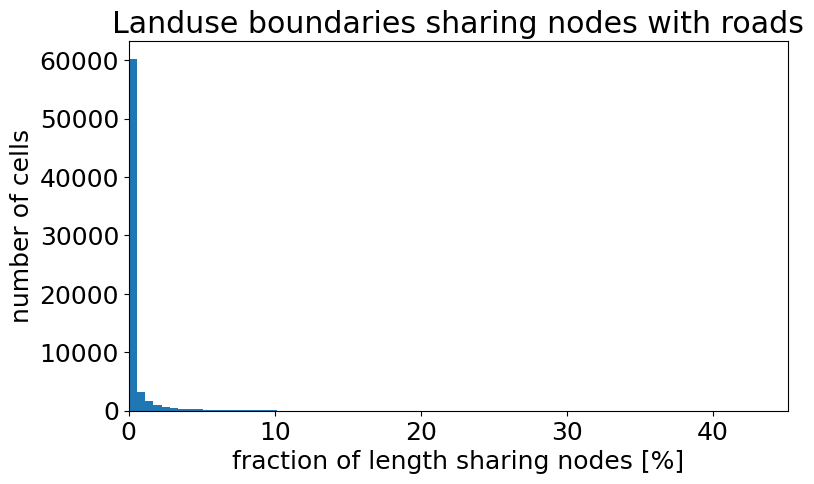

In [20]:
result = send_sql(conn, "SELECT landuse_boundaries_on_roads_fraction FROM roads_landuse_boundary_fraction_per_cell WHERE road_network_length > 0.0;", return_result=True)
fig, ax = plt.subplots(figsize=figsize_in(850, 480))
dist = [row[0]*100 for row in result]
ax.hist(dist, bins=80)
ax.set_xlabel('fraction of length sharing nodes [%]')
ax.set_title('Landuse boundaries sharing nodes with roads')
ax.set_ylabel('number of cells')
ax.set_xlim(0.0, max(dist))
plt.show()
fig.savefig('talk/plots/sticky_landuse_of_landuse_histogram.svg', facecolor='white', bbox_inches='tight')

Determine per cell how large the proportion of landuse boundaries glued to other landuse boundaries compared to all landuse boundaries is.

In [23]:
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_landuse_boundaries_geom_idx ON landuse_landuse_boundaries USING gist(geom);")
#sql = """
#DROP TABLE IF EXISTS landuse_boundaries_per_city;
#CREATE TABLE landuse_boundaries_per_city AS
#SELECT
#    ST_CollectionExtract(ST_Collect(
#      CASE
#        WHEN ST_Within(lb.geom, c.geom) THEN lb.geom
#        ELSE ST_Intersection(lb.geom, c.geom)
#      END
#    ), 2) AS geom,
#    c.area_id AS city_id
#  FROM cities AS c
#  LEFT OUTER JOIN landuse_boundaries AS lb
#    ON
#      c.geom && lb.geom
#      AND ST_Intersects(c.geom, lb.geom)
#  GROUP BY c.area_id;
#"""
#send_sql(conn, sql)
sql = """
DROP TABLE IF EXISTS landuse_landuse_boundaries_per_cell;
CREATE TABLE landuse_landuse_boundaries_per_cell AS
SELECT
    ST_CollectionExtract(ST_Collect(
      CASE
        WHEN ST_Within(llb.geom, c.geom) THEN llb.geom
        ELSE ST_Intersection(llb.geom, c.geom)
      END
    ), 2) AS geom,
    c.id AS cell_id
  FROM grid_cells AS c
  LEFT OUTER JOIN landuse_landuse_boundaries AS llb
    ON
      c.geom && llb.geom
      AND ST_Intersects(c.geom, llb.geom)
  GROUP BY c.id;
"""
send_sql(conn, sql) # Baden-Württemberg: 20 seconds, 1049 seconds
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_boundaries_per_cell_cell_id ON landuse_boundaries_per_cell USING btree(cell_id);")
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_landuse_boundaries_per_cell_cell_id ON landuse_landuse_boundaries_per_cell USING btree(cell_id);")
sql = """DROP TABLE IF EXISTS landuse_landuse_boundary_fraction_per_cell;
CREATE TABLE landuse_landuse_boundary_fraction_per_cell AS
SELECT
    bb_len/b_len AS bounds_fraction,
    bb_len AS boundary_boundary_length,
    b_len boundary_length,
    cell_id,
    cell_geom,
    coverage_fraction
FROM (
  SELECT
    -- Multiplication by 2 because boundary-boundary intersections were deduplicated in a previous step.
    ST_Length(bb.geom::geography) * 2 AS bb_len,
    ST_Length(b.geom::geography) AS b_len,
    cov.area_size/cov.cell_area AS coverage_fraction,
    c.id AS cell_id,
    c.geom AS cell_geom
  FROM grid_cells AS c
  LEFT OUTER JOIN landuse_landuse_boundaries_per_cell AS bb
    ON bb.cell_id = c.id
  LEFT OUTER JOIN landuse_boundaries_per_cell AS b
    ON b.cell_id = c.id
  LEFT OUTER JOIN landuse_coverage_per_cell AS cov
    ON cov.cell_id = c.id
  ) AS a;
"""
send_sql(conn, sql) # Baden-Württemberg: 51 seconds, Germany: 202 seconds

Executed SQL command in 0.001 seconds.
Executed SQL command in 1049.092 seconds, affected 73944 rows.
Executed SQL command in 0.173 seconds.
Executed SQL command in 0.071 seconds.
Executed SQL command in 1793.120 seconds, affected 73944 rows.


When inspecting the `landuse_landuse_boundary_fraction_per_cell` table, you should keep in mind that cells without almost complete landuse coverage will have high fractions of landuse boundaries not sharing nodes with other landuse boundaries because they have no neighbours.

## Landuse polygons almost touching each other or roads

As a first step, we find all landuse boundary line which are not shared with other landuse polygons.
Shorten the linestrings and caluclate buffers.

In [ ]:
#send_sql(conn, "DROP TABLE IF EXISTS lonely_landuse_boundaries;")
buffer_dist = 0.5
sql = """DROP TABLE IF EXISTS landuse_boundaries_not_touching_others;
CREATE TABLE landuse_boundaries_not_touching_others AS
SELECT
    ST_Difference(
      lb.geom, ST_Collect(COALESCE(llb.geom, ST_SetSRID(ST_GeomFromText('LINESTRING EMPTY'), 4326)))
    ) AS geom,
    lb.feature AS feature,
    lb.area_id AS area_id
  FROM landuse_boundaries AS lb
  LEFT OUTER JOIN landuse_landuse_boundaries AS llb
    ON lb.geom && llb.geom AND ST_Intersects(lb.geom, llb.geom)
  GROUP BY lb.area_id, lb.feature, lb.geom;
"""
send_sql(conn, sql)
send_sql(conn, "CREATE INDEX landuse_boundaries_not_touching_others_geom ON landuse_boundaries_not_touching_others USING gist(geom);")
sql = """DROP TABLE IF EXISTS landuse_boundaries_not_touching_roads_and_landuse;
CREATE TABLE landuse_boundaries_not_touching_roads_and_landuse AS
SELECT
    1.0 / cos(RADIANS(ST_Y(ST_StartPoint(geom)))) AS mercator_factor,
    ST_Length(geom::geography) AS length,
    geom,
    feature,
    area_id
  FROM (
    SELECT
        (ST_Dump(
          ST_CollectionExtract(
            ST_Difference(
              c.geom,
              ST_Collect(COALESCE(rlb.geom, ST_SetSRID(ST_GeomFromText('LINESTRING EMPTY'), 4326)))
            ),
          2)
        )).geom AS geom,
        c.feature AS feature,
        c.area_id AS area_id
      FROM landuse_boundaries_not_touching_others AS c
      LEFT OUTER JOIN roads_as_landuse_boundaries AS rlb
        ON c.geom && rlb.geom AND ST_Intersects(c.geom, rlb.geom)
      GROUP BY c.area_id, c.feature, c.geom
  ) AS d;
"""
send_sql(conn, sql)
sql = """DROP TABLE IF EXISTS lonely_landuse_boundaries;
CREATE TABLE lonely_landuse_boundaries AS
SELECT
    ST_Transform(ST_LineSubstring(geom_3857, cutoff_fraction, 1.0-cutoff_fraction), 4326)::geography AS geog_for_buffer,
    geom AS geom,
    geom::geography AS geog,
    feature,
    mercator_factor,
    area_id
  FROM (
    SELECT
        -- buffer_dist multiplied by Mercator factor because ST_LineSubString works with Geometry type.
        ({} * mercator_factor) / length AS cutoff_fraction,
        mercator_factor,
        ST_Transform(geom, 3857) AS geom_3857,
        geom,
        feature,
        area_id
      FROM landuse_boundaries_not_touching_roads_and_landuse
      WHERE length > 5 * {}
  ) AS a;
""".format(buffer_dist * 2.0, buffer_dist * 2.0)
send_sql(conn, sql)
# Baden-Württemberg: 260 seconds, Germany: max. 2211 seconds

Find intersections:

In [ ]:
send_sql(conn, "DROP TABLE IF EXISTS closeby_landuse_intersections;")
send_sql(conn, "CREATE INDEX IF NOT EXISTS lonely_landuse_boundaries_buffer ON lonely_landuse_boundaries USING gist(geog_for_buffer);") # BW: 7 seconds
send_sql(conn, "ALTER TABLE streets ADD COLUMN IF NOT EXISTS geog geography; UPDATE streets SET geog = geom::geography WHERE geog IS NULL;") # BW: 63 seconds
sql = """CREATE INDEX IF NOT EXISTS streets_geog ON streets USING gist(geog)
  WHERE highway IN ('motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link',
      'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'unclassified', 'residential',
      'living_street', 'pedestrian', 'service', 'track', 'busway', 'bus_guideway')
    OR railway IN ('rail', 'narrow_gauge', 'tram', 'subway', 'ligh_rail', 'monorail', 'funicular');
"""
send_sql(conn, sql) # BW: 28 seconds, Germany: 154 seconds
sql = """CREATE TABLE closeby_landuse_intersections AS
SELECT
    ST_CollectionExtract(ST_Intersection(ST_Buffer(a.geog_for_buffer, {buffer_dist})::geometry, b.geom), 2) AS geom,
    a.area_id AS id1,
    b.area_id AS id2,
    a.feature AS feature1,
    b.feature AS feature2,
    TRUE AS touches_to_landuse
  FROM lonely_landuse_boundaries AS a
  JOIN lonely_landuse_boundaries AS b
    ON ST_DWithin(a.geog_for_buffer, b.geog, {buffer_dist}) AND a.area_id < b.area_id
UNION ALL
SELECT
    ST_CollectionExtract(ST_Intersection(ST_Buffer(a.geog_for_buffer, {buffer_dist})::geometry, r.geom), 2) AS geom,
    a.area_id AS id1,
    r.way_id AS id2,
    a.feature AS feature1,
    COALESCE(r.highway, r.railway) AS feature2,
    FALSE AS touches_to_landuse
  FROM lonely_landuse_boundaries AS a
  JOIN streets AS r
    ON ST_DWithin(a.geog_for_buffer, r.geog, {buffer_dist})
      AND (
        r.highway IN ('motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link',
          'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'unclassified', 'residential',
          'living_street', 'pedestrian', 'service', 'track', 'busway', 'bus_guideway')
        OR r.railway IN ('rail', 'narrow_gauge', 'tram', 'subway', 'ligh_rail', 'monorail', 'funicular')
      );
""".format(buffer_dist=buffer_dist)
send_sql(conn, sql) # BW: 437 seconds, Germany: 5272 seconds

Table of length of boundaries with near-by touches per cell:

In [ ]:
send_sql(conn, "DROP TABLE IF EXISTS closeby_landuse_intersections_per_cell;")
send_sql(conn, "CREATE INDEX IF NOT EXISTS closeby_landuse_intersections_geom ON closeby_landuse_intersections USING gist(geom);")
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_landuse_boundary_fraction_per_cell_cell_id ON landuse_landuse_boundary_fraction_per_cell USING btree(cell_id);")
sql = """CREATE TABLE closeby_landuse_intersections_per_cell AS
SELECT
    ST_Length(ST_CollectionExtract(ST_Collect(ST_Intersection(i.geom, c.geom)), 2)::geography) AS length,
    i.touches_to_landuse AS touches_to_landuse,
    llb.boundary_length AS boundary_length,
    c.id AS cell_id,
    c.geom AS cell_geom
  FROM grid_cells AS c
  JOIN closeby_landuse_intersections AS i
    ON c.geom && i.geom AND ST_Intersects(c.geom, i.geom)
  JOIN landuse_landuse_boundary_fraction_per_cell AS llb
    ON c.id = llb.cell_id
  GROUP BY c.id, i.touches_to_landuse, llb.boundary_length, c.geom;
"""
send_sql(conn, sql) # BW: 12 seconds, Germany: 117 seconds

## Age of landuse polygons

In [34]:
send_sql(conn, "DROP TABLE IF EXISTS landuse_nodes;")
send_sql(conn, "CREATE INDEX IF NOT EXISTS land_rel_id_idx ON land USING btree(area_id) WHERE area_id < 0;")

# very slow (I stopped the query after more than 5 minutes)
#sql = """CREATE TABLE landuse_relation_nodes AS
#SELECT
#    relways.landuse_id AS landuse_id,
#    relways.feature AS feature,
#    n.id AS node_id,
#    ST_SetSRID(ST_MakePoint(n.lon, n.lat), 4326) AS node_geom,
#    n.created AS last_modified,
#    n.version AS version
#  FROM planet_osm_nodes AS n
#  JOIN (
#    SELECT
#        l.area_id AS landuse_id,
#        l.feature AS feature,
#        w.id AS way_id,
#        w.nodes AS nodes
#      FROM land AS l
#      JOIN planet_osm_rels AS r ON -l.area_id = r.id AND l.area_id < 0
#      JOIN planet_osm_ways AS w ON r.members @> ('[{"ref": ' || w.id::TEXT || ', "type": "W"}]')::jsonb
#  ) AS relways ON n.id = ANY(relways.nodes);
#"""
sql = """CREATE OR REPLACE FUNCTION convert_coord(c INTEGER) RETURNS FLOAT AS $$
BEGIN
  IF c IS NULL THEN
    RETURN NULL;
  END IF;
  RETURN c::FLOAT * 10.0^(-7);
END;
$$ LANGUAGE plpgsql STABLE LEAKPROOF PARALLEL SAFE STRICT;

CREATE TABLE landuse_nodes AS
WITH landuse_relation_nodes AS (
SELECT
    r.landuse_id AS landuse_id,
    r.feature AS feature,
    n.id AS node_id,
    ST_SetSRID(ST_MakePoint(convert_coord(n.lon), convert_coord(n.lat)), 4326) AS geom,
    n.created AS last_modified,
    n.version AS version
  FROM planet_osm_ways AS w
  JOIN (
    SELECT
        l.area_id AS landuse_id,
        l.feature AS feature,
        jsonb_path_query(r.members, '($[*] ? (@.type == "W")).ref') AS way_id
      FROM land AS l
      JOIN planet_osm_rels AS r ON -l.area_id = r.id AND l.area_id < 0
  ) AS r ON r.way_id::BIGINT = w.id
  JOIN planet_osm_nodes AS n ON n.id = ANY(w.nodes)
)
-- The pure way-nodes part (simple polygons) takes 12 s.
SELECT
    l.area_id AS landuse_id,
    l.feature AS feature,
    n.id AS node_id,
    ST_SetSRID(ST_MakePoint(convert_coord(n.lon), convert_coord(n.lat)), 4326) AS geom,
    n.created AS last_modified,
    n.version AS version
  FROM planet_osm_ways AS w
  -- Instead of joining with the land table, we could write a WHERE condition using the same implementation as the Lua code.
  JOIN land AS l ON l.area_id = w.id
  JOIN planet_osm_nodes AS n ON n.id = ANY(w.nodes)
UNION ALL
-- The relations-way-nodes part (multipolygons) takes 3 s.
SELECT * FROM landuse_relation_nodes;
"""
send_sql(conn, sql) # Baden-Württemberg: 49 seconds, Germany: 382 seconds, Europe: 3532 s
send_sql(conn, "CREATE INDEX landuse_nodes_geom_idx ON landuse_nodes USING gist(geom);") # Baden-Württemberg: 196 seconds, Germany: 1409 seconds, Europe: 15329 s
send_sql(conn, "CREATE INDEX landuse_nodes_area_id_idx ON landuse_nodes USING btree(landuse_id);") # Baden-Württemberg: 7 seconds, Germany: 45 seconds, Europe: 446s

Executed SQL command in 0.009 seconds.
Executed SQL command in 0.001 seconds.
Executed SQL command in 3532.123 seconds, affected 1333186661 rows.
Executed SQL command in 15329.063 seconds.
Executed SQL command in 446.097 seconds.


Find median age of landuse per polygon:

In [35]:
send_sql(conn, "CREATE INDEX IF NOT EXISTS landuse_nodes_landuse_id_node_id_mod10 ON landuse_nodes using btree(landuse_id) where node_id % 10 = 0;")
sql = """DROP TABLE IF EXISTS landuse_polygon_age;
CREATE TABLE landuse_polygon_age AS
SELECT
    n.landuse_id,
    --n.feature,
    --l.tags->'source' AS source,
    --MIN(n.last_modified) AS oldest_timestamp,
    --MAX(n.last_modified) AS newest_timestamp,
    to_timestamp((PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY EXTRACT(EPOCH FROM n.last_modified)))::BIGINT) AS median_timestamp,
    --l.geom AS geom,
    COUNT(1) AS node_count
  FROM landuse_nodes AS n
  JOIN land AS l
    ON n.landuse_id = l.area_id
      -- hack to reduce size because we ran into '"base/pgsql_tmp/pgsql_tmp2805419.1513": No space left on device'
      AND n.node_id % 10 = 0
  GROUP BY n.landuse_id;
  --GROUP BY n.landuse_id, n.feature, l.tags->'source', l.geom;
"""
send_sql(conn, sql) # Baden-Württemberg: 86 seconds (105 seconds with source), Germany: 987 seconds, Europe (simplified): 

Executed SQL command in 0.184 seconds.
Failed to execute SQL statement:
b"CREATE TABLE landuse_polygon_age AS\nSELECT\n    n.landuse_id,\n    n.feature,\n    --l.tags->'source' AS source,\n    --MIN(n.last_modified) AS oldest_timestamp,\n    --MAX(n.last_modified) AS newest_timestamp,\n    to_timestamp((PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY EXTRACT(EPOCH FROM n.last_modified)))::BIGINT) AS median_timestamp,\n    COUNT(1) AS node_count,\n    l.geom AS geom\n  FROM landuse_nodes AS n\n  JOIN land AS l\n    ON n.landuse_id = l.area_id\n  GROUP BY n.landuse_id, n.feature, l.geom;\n  --GROUP BY n.landuse_id, n.feature, l.tags->'source', l.geom;\n"
Reason: could not write to file "base/pgsql_tmp/pgsql_tmp2805419.1513": No space left on device

Executed SQL command in 16411.715 seconds.


Get node age per municipality:

In [36]:
send_sql(conn, "DROP TABLE IF EXISTS landuse_node_age_per_cell;")
sql = """CREATE TABLE landuse_node_age_per_cell AS
SELECT
    --MIN(n.last_modified) AS oldest_timestamp,
    --MAX(n.last_modified) AS newest_timestamp,
    to_timestamp((PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY EXTRACT(EPOCH FROM n.last_modified)))::BIGINT) AS median_timestamp,
    COUNT(1) AS node_count,
    c.id AS cell_id,
    ST_Area(c.geom) AS area
  FROM grid_cells AS c
  JOIN landuse_nodes AS n
    ON c.geom && n.geom AND ST_Intersects(c.geom, n.geom)
  GROUP BY c.id, c.geom;
"""
send_sql(conn, sql) # Europe: 3312 seconds

Executed SQL command in 0.001 seconds.
Executed SQL command in 3311.761 seconds, affected 71885 rows.


Create a view which converts the dates into Unix timestamps (for MapLibre):

In [40]:
sql = """DROP TABLE IF EXISTS landuse_node_age_per_cell_unix;
-- A btree(cell_id) index on landuse_node_age_per_cell does not make the query faster.
CREATE TABLE landuse_node_age_per_cell_unix AS
SELECT
    --EXTRACT(EPOCH FROM oldest_timestamp)::BIGINT AS oldest_timestamp,
    --EXTRACT(EPOCH FROM newest_timestamp)::BIGINT AS newest_timestamp,
    EXTRACT(EPOCH FROM median_timestamp)::BIGINT AS median_timestamp,
    node_count,
    n.cell_id,
    n.area,
    c.geom,
    c.country_code
  FROM landuse_node_age_per_cell AS n
  JOIN grid_cells AS c ON c.id = n.cell_id;
"""
send_sql(conn, sql) # BW: 1 second

Executed SQL command in 0.446 seconds, affected 71885 rows.


Histogram of the age of nodes of polygons:

In [ ]:
result = send_sql(conn, "SELECT EXTRACT(EPOCH FROM median_timestamp)::BIGINT AS median_timestamp FROM landuse_polygon_age;", return_result=True)
fig, ax = plt.subplots(figsize=figsize_in(850, 480))
print('converting data')
import datetime
dist = [datetime.datetime.fromtimestamp(row[0]) for row in result]
print('plotting')
ax.hist(dist, bins=120)
#ax.set_xlabel('letzte Änderung')
ax.set_ylabel('number of polygons')
ax.set_xlim(min(dist), max(dist))
#fig.subplots_adjust(bottom=0.20)
#ax.set_title('Median der letzten Änderung an den Nodes von Landuse-Polygonen')
plt.show()
fig.savefig('talk/plots/polygon_median_age_histogram.svg', facecolor='white', bbox_inches='tight')

Executed SQL command in 16.839 seconds, affected 33470493 rows.
converting data
plotting


The same for cells and their median modification date:

In [ ]:
result = send_sql(conn, "SELECT median_timestamp AS median_timestamp FROM landuse_node_age_per_cell_unix;", return_result=True)
plt.rc('font', size=18)
fig, ax = plt.subplots(figsize=figsize_in(850, 480))
print('converting data')
import datetime
dist = [datetime.datetime.fromtimestamp(row[0]) for row in result]
print('plotting')
ax.hist(dist, bins=120)
#ax.set_xlabel('letzte Änderung der Nodes')
ax.set_ylabel('number of cells')
#fig.subplots_adjust(bottom=0.20)
ax.set_xlim(min(dist), max(dist))
#ax.set_title('Median der letzten Änderung an den Landuse-Nodes je Gemeinde')
plt.show()
fig.savefig('talk/plots/node_median_age_histogram_municipality.svg', facecolor='white', bbox_inches='tight')

Medium, minimum and maximum node age per country:

In [44]:
send_sql(conn, "CREATE INDEX IF NOT EXISTS grid_cells_country_code ON grid_cells USING btree(country_code);")
sql = """DROP TABLE IF EXISTS landuse_node_age_per_country;
CREATE TABLE landuse_node_age_per_country AS
SELECT
    to_timestamp((PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY EXTRACT(EPOCH FROM n.last_modified)))::BIGINT) AS median_timestamp,
    COUNT(1) AS node_count,
    c.country_code AS country_code,
    SUM(ST_Area(c.geom::geography)) AS area
  FROM grid_cells AS c
  JOIN landuse_nodes AS n
    ON c.geom && n.geom AND ST_Intersects(c.geom, n.geom) AND c.id % 100 = 0
  GROUP BY c.country_code;
"""
send_sql(conn, sql) # expected to take about 8000 seconds for Europe

Executed SQL command in 0.001 seconds.
Failed to execute SQL statement:
b'DROP TABLE IF EXISTS landuse_node_age_per_country;\nCREATE TABLE landuse_node_age_per_country AS\nSELECT\n    --MIN(n.last_modified) AS oldest_timestamp,\n    --MAX(n.last_modified) AS newest_timestamp,\n    to_timestamp((PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY EXTRACT(EPOCH FROM n.last_modified)))::BIGINT) AS median_timestamp,\n    COUNT(1) AS node_count,\n    c.country_code AS country_code\n  FROM grid_cells AS c\n  JOIN landuse_nodes AS n\n    ON c.geom && n.geom AND ST_Intersects(c.geom, n.geom) AND n.node_id % 1000 = 0\n  GROUP BY c.country_code;\n'
Reason: canceling statement due to user request

Executed SQL command in 257.086 seconds.


Plot it:

Executed SQL command in 0.001 seconds, affected 39 rows.
converting data
plotting


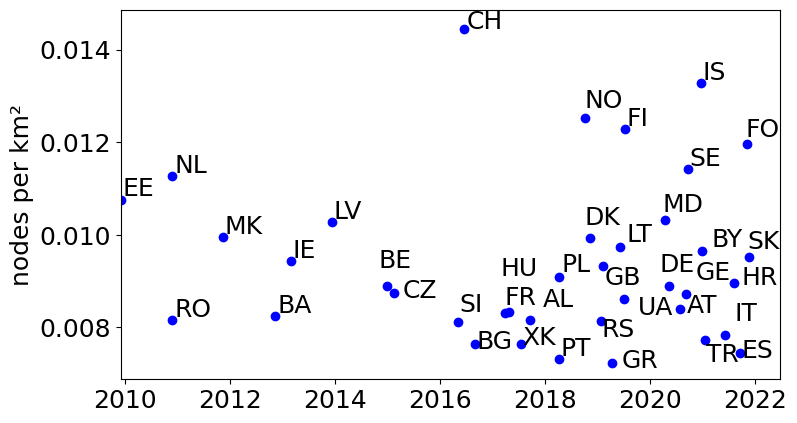

In [15]:
sql = """SELECT
    EXTRACT(EPOCH FROM median_timestamp)::BIGINT AS median_timestamp,
    country_code,
    node_count / area AS nodes_per_area
  FROM landuse_node_age_per_country
  WHERE country_code NOT IN ('am', 'az', 'ir', 'ru');
"""
result = send_sql(conn, sql, return_result=True)
plt.rc('font', size=18)
fig, ax = plt.subplots(figsize=figsize_in(850, 480))
print('converting data')
import datetime
dates = [datetime.datetime.fromtimestamp(row[0]) for row in result]
#dates = [datetime.datetime.fromtimestamp(row[0]) for row in result]
nodes_per_area = [row[2] * 10**6 for row in result]
country_codes = [row[1].upper() for row in result]
print('plotting')
scatter = ax.scatter(dates, nodes_per_area, c="blue")
texts = []
for i, label in enumerate(country_codes):
    #ax.annotate(label, (dates[i], nodes_per_area[i]), xytext=(dates[i]+datetime.timedelta(days=120), nodes_per_area[i]+0.5), arrowprops={"arrowstyle": "-"})
    texts.append(ax.text(dates[i], nodes_per_area[i], label))
ax.set_xlim(min(dates), max(dates))
import adjustText
adjustText.adjust_text(texts, expand_axes=True)
ax.set_ylabel('nodes per km²')
#ax.set_xlabel('letzte Änderung der Nodes')
#fig.subplots_adjust(bottom=0.20)
#ax.set_title('Median der letzten Änderung an den Landuse-Nodes je Gemeinde')
plt.show()
fig.savefig('talk/plots/node_median_age_scatter_by_country.svg', facecolor='white', bbox_inches='tight')